In [ ]:
# General Imports
import os
import imagehash
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from math import inf as INFINITE

# PyTorch Imports
import torch
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Sklearn Imports
from sklearn.metrics import precision_score, recall_score

# Huggingface Imports
from datasets import load_dataset, concatenate_datasets, ClassLabel

# Data Preprocessing

### Datasets used
- https://huggingface.co/datasets/Simezu/brain-tumour-MRI-scan [huggingface] - 5.71k - 1.31k
- https://huggingface.co/datasets/PranomVignesh/MRI-Images-of-Brain-Tumor [huggingface] - 3.76k - 1.6k
- https://huggingface.co/datasets/rhyssh/Brain-Tumor-MRI-Dataset-Training - 800

In [ ]:
# Load the dataset
ds1 = load_dataset("Simezu/brain-tumour-MRI-scan")
ds2 = load_dataset("PranomVignesh/MRI-Images-of-Brain-Tumor")
ds3 = load_dataset("rhyssh/Brain-Tumor-MRI-Dataset-Training")

In [1]:
def harmonize_labels(x, no_tumor_column):
    label_map = {}
    for i in range(4):
        if i == no_tumor_column:
            label_map[i] = 0
        else:
            label_map[i] = 1

    x["label"] = label_map.get(x["label"])
    return x

labels = ClassLabel(names=["notumor", "tumor"])

# Apply label harmonization on ds1
no_tumor_column = ds1["train"].features['label'].str2int('1-notumor')
ds1 = ds1.map(harmonize_labels, fn_kwargs={"no_tumor_column": no_tumor_column})
ds1 = ds1.cast_column("label", labels)

# Apply label harmonization on ds2
no_tumor_column = ds2["train"].features['label'].str2int('no-tumor')
ds2 = ds2.map(harmonize_labels, fn_kwargs={"no_tumor_column": no_tumor_column})
ds2 = ds2.cast_column("label", labels)

# Apply label harmonization on ds3
no_tumor_column = ds3["train"].features['label'].str2int('notumor')
ds3 = ds3.map(harmonize_labels, fn_kwargs={"no_tumor_column": no_tumor_column})
ds3 = ds3.cast_column("label", labels)

ds_train = concatenate_datasets([ds1["train"], ds2["train"], ds3["train"]])
ds_test = concatenate_datasets([ds1["test"], ds2["test"], ds2["validation"]])

# Convert to pandas DF
df_train = ds_train.to_pandas()
df_test = ds_test.to_pandas()

# Check for duplicates and remove
def image_hash(image_path):
    return str(imagehash.average_hash(Image.open(image_path["path"])))

def remove_duplicates(df):
    df["image_hash"] = df["image"].apply(image_hash)
    df_dedup = df.drop_duplicates(subset="image_hash")
    print(f"Removed {len(df) - len(df_dedup)} duplicates")
    return df_dedup.drop(columns="image_hash")

def remove_test_from_train(df_train, df_test):
    train_hashes = set(df_train["image"].apply(image_hash))
    test_hashes = set(df_test["image"].apply(image_hash))
    common_hashes = train_hashes.intersection(test_hashes)

    df_train_clean = df_train[~df_train["image"].apply(image_hash).isin(common_hashes)]
    print(f"Removed {len(df_train) - len(df_train_clean)} images from train set that were present in test set")
    return df_train_clean

df_train = remove_duplicates(df_train)
df_test = remove_duplicates(df_test)

df_train = remove_test_from_train(df_train, df_test)

print(f"Train: {len(df_train)}")
print(f"Test: {len(df_test)}")
print(f"Train/Test Ratio: {len(df_train) / (len(df_train) + len(df_test)):.2f}")

Removed 6142 duplicates
Removed 1269 duplicates
Removed 1091 images from train set that were present in test set
Train: 3038
Test: 1652
Train/Test Ratio: 0.65


# Exploratory Data Analysis (EDA)
- Check Data Type : ["image", "label"]
- Plot Bar Graphs of Unique Values : Balanced
- Sample and Check Images : Grayscale

In [2]:
def column_summary(df: pd.DataFrame) -> pd.DataFrame:
    summary_data = []

    for col_name in df.columns:

        col_dtype = df[col_name].dtype
        n_nulls = df[col_name].isnull().sum()
        n_not_nulls = df[col_name].notnull().sum()
        if (df[col_name].dtype == "object"):
            n_distinct = None
            distinct_value_counts = None

        else:
            n_distinct = df[col_name].nunique()
            if n_distinct <= 10:
                distinct_value_counts = df[col_name].value_counts().to_dict()
            else:
                distinct_value_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_value_counts = {k: v for k, v in sorted(distinct_value_counts.items(), key=lambda item: item[1], reverse=True)}

        summary = {
            "dtype": col_dtype,
            "n_null": n_nulls,
            "n_not_null": n_not_nulls,
            "n_distinct": n_distinct,
            "distinct": distinct_value_counts
        }
        summary_data.append(summary)

    summary_df = pd.DataFrame(summary_data, index=df.columns)
    return summary_df

print(column_summary(df_train))
print(column_summary(df_test))

        dtype  n_null  n_not_null  n_distinct           distinct
image  object       0        3038         NaN               None
label   int64       0        3038         2.0  {1: 2590, 0: 448}
        dtype  n_null  n_not_null  n_distinct           distinct
image  object       0        1652         NaN               None
label   int64       0        1652         2.0  {1: 1314, 0: 338}


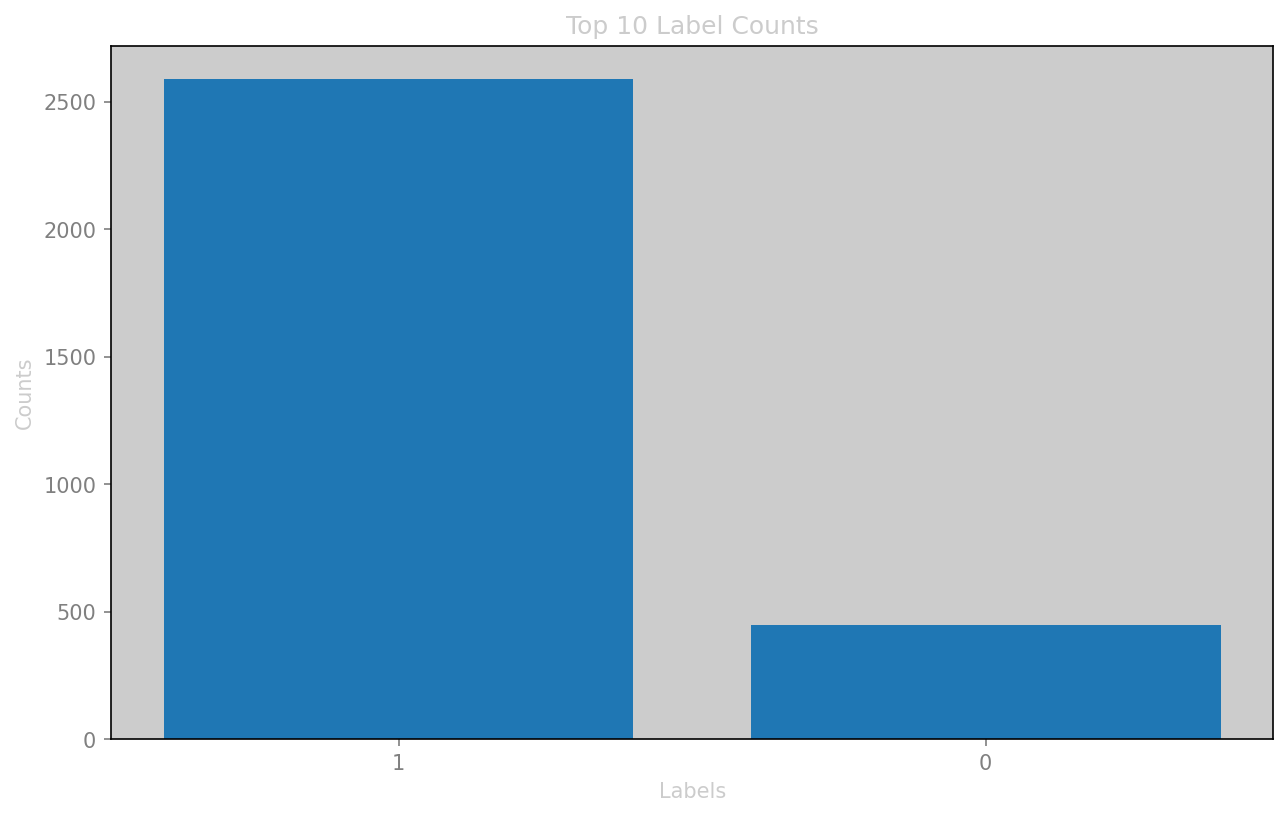

In [3]:
value_counts = df_train["label"].value_counts().head(10).to_dict()
value_counts = sorted(value_counts.items(), key=lambda item: item[1], reverse=True)
k = [str(s[0]) for s in value_counts]
v = [s[1] for s in value_counts]

plt.figure(figsize=(10, 6))
plt.bar(k, v)
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Top 10 Label Counts")
plt.show()

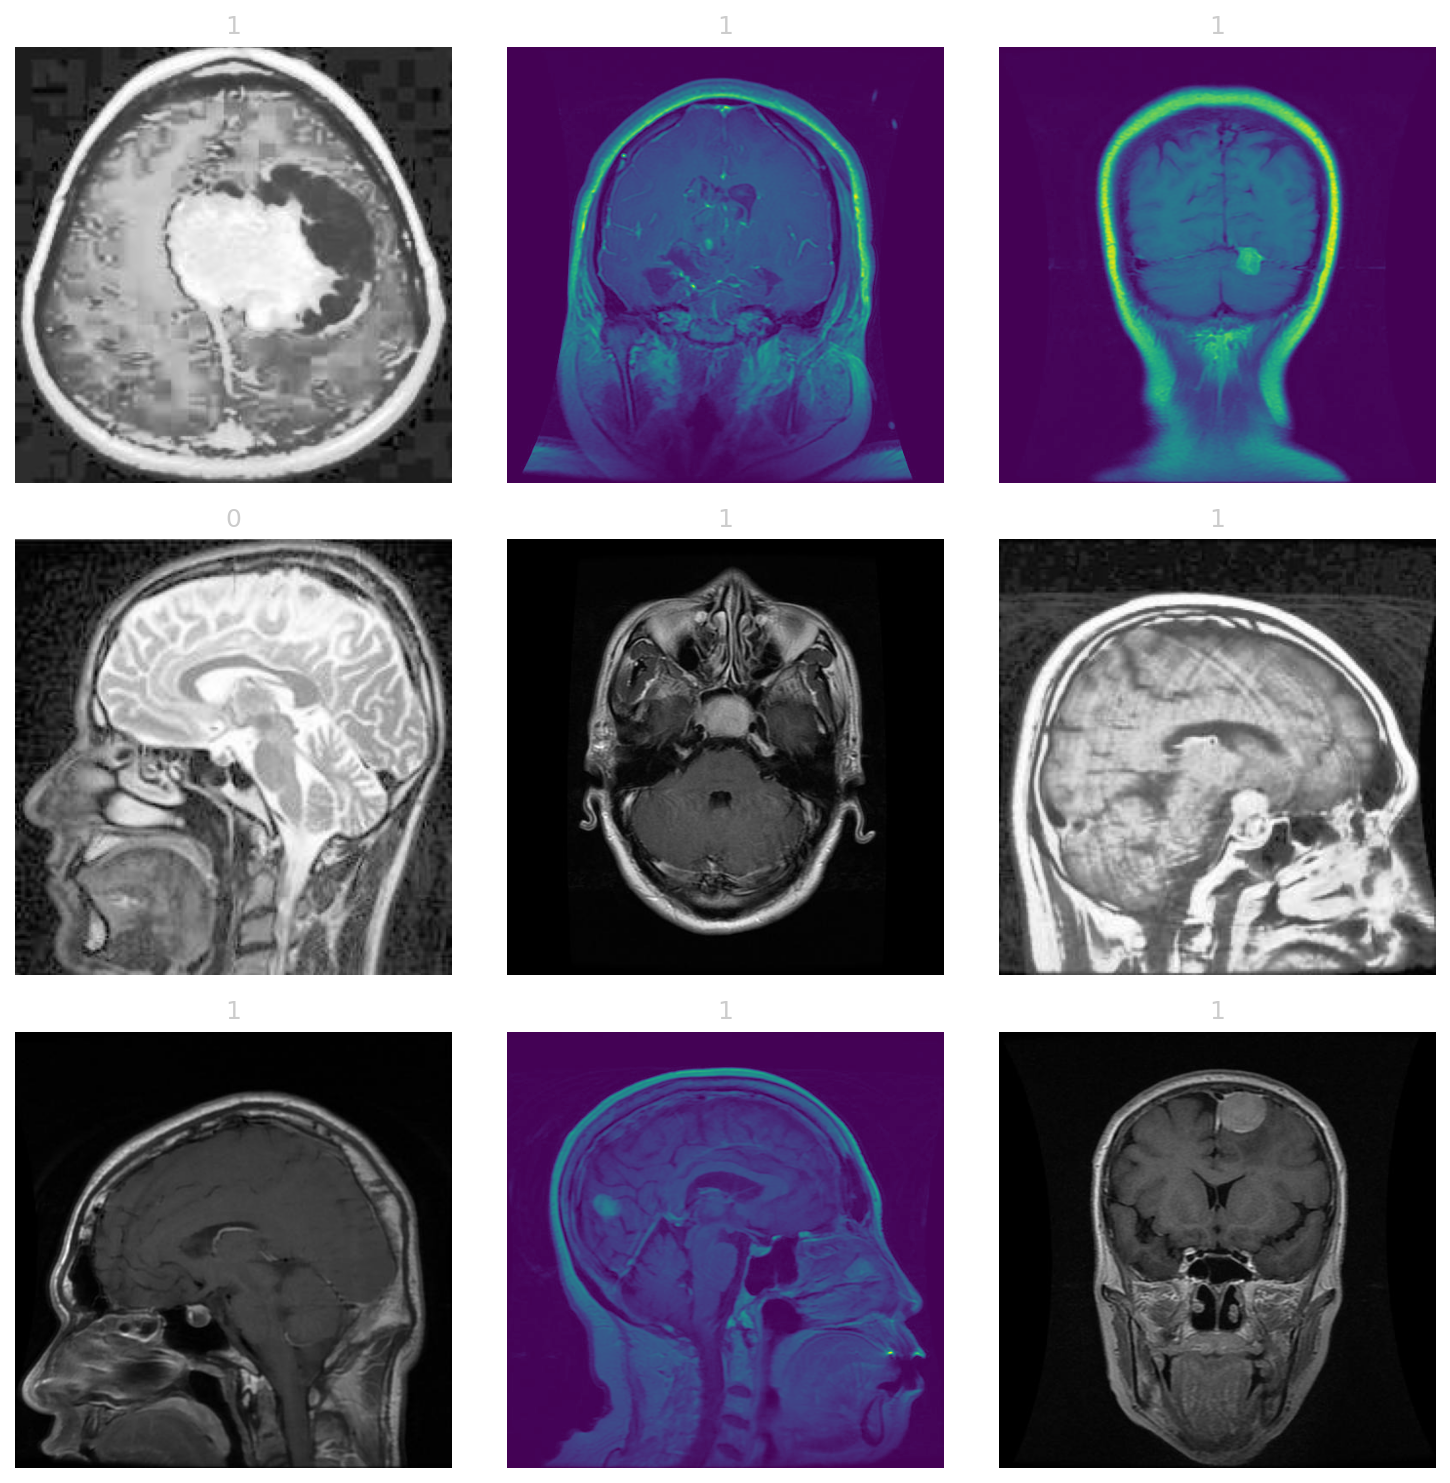

In [4]:
sample_images = df_train.sample(9)
fig, axes = plt.subplots(3, 3, figsize=(10,10))
for ax, (img_path, label) in zip(axes.flatten(), sample_images.itertuples(index=False)):
    img = Image.open(img_path["path"])
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")
plt.tight_layout()
plt.show()

# Custom Dataset Definition
- Define a Custom Dataset Class
- Create DataLoaders
- Oversampling minority class

In [ ]:
class TumorDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform: bool = None) -> None:
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]["path"]
        label = self.df.iloc[idx, 1]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TumorDataset(df_train, transform)
test_dataset = TumorDataset(df_test, transform)

class_counts = df_train["label"].value_counts()
weights = 1.0 / class_counts
sample_weights = df_train['label'].map(weights)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64)

# Model Finetuning
- Use Resnet50 and Modify input and output feature count in fc

In [ ]:
model = models.resnet50(pretrained=True)

n_classes = len(df_train["label"].unique())
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),  # to prevent overfitting
    torch.nn.Linear(model.fc.in_features, n_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training Hyperparameters

In [5]:
def get_best_loss():
    losses = []
    for file in os.listdir():
        if file.startswith("model-") and file.endswith(".pth"):
            losses.append(float(file.split("-")[1].split(".pth")[0]))
    if not len(losses):
        return INFINITE
    return min(losses)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

model.eval()
test_loss = 0.0
test_correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
print(f"Initial Test Loss: {test_loss:.4f}")
print(f"Initial Test Accuracy: {100*test_correct/total:.2f}%")

Initial Test Loss: 21.2399
Initial Test Accuracy: 22.70%


# Training Loop

In [6]:
n_epochs = 20
train_losses = []
test_losses = []
accuracies = []
precisions = []
recalls = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    print(f"Epoch: {epoch + 1}")
    print(f"\tTrain Loss: {train_loss:.4f}")

    model.eval()
    test_loss = 0.0
    test_correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    accuracy = 100 * test_correct / total
    accuracies.append(accuracy)
    precision = precision_score(all_labels, all_predicted, average='weighted')
    precisions.append(precision)
    recall = recall_score(all_labels, all_predicted, average='weighted')
    recalls.append(recall)

    print(f"\tTest Loss: {test_loss:.4f}")
    print(f"\tTest Accuracy: {accuracy:.2f}%")
    print(f"\tTest Precision: {precision:.4f}")
    print(f"\tTest Recall: {recall:.4f}")

    if test_loss < get_best_loss():
        model_path = f"model-{test_loss:.4f}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}")
    print()

Epoch: 1
	Train Loss: 0.0916
	Test Loss: 0.1690
	Test Accuracy: 93.83%
	Test Precision: 0.9466
	Test Recall: 0.9383
Model saved at model-0.1690.pth

Epoch: 2
	Train Loss: 0.0159
	Test Loss: 0.0735
	Test Accuracy: 97.34%
	Test Precision: 0.9748
	Test Recall: 0.9734
Model saved at model-0.0735.pth

Epoch: 3
	Train Loss: 0.0126
	Test Loss: 0.0663
	Test Accuracy: 98.06%
	Test Precision: 0.9805
	Test Recall: 0.9806
Model saved at model-0.0663.pth

Epoch: 4
	Train Loss: 0.0066
	Test Loss: 0.0877
	Test Accuracy: 97.40%
	Test Precision: 0.9759
	Test Recall: 0.9740

Epoch: 5
	Train Loss: 0.0070
	Test Loss: 0.1147
	Test Accuracy: 96.67%
	Test Precision: 0.9695
	Test Recall: 0.9667

Epoch: 6
	Train Loss: 0.0007
	Test Loss: 0.0708
	Test Accuracy: 97.76%
	Test Precision: 0.9781
	Test Recall: 0.9776

Epoch: 7
	Train Loss: 0.0002
	Test Loss: 0.0681
	Test Accuracy: 97.94%
	Test Precision: 0.9797
	Test Recall: 0.9794

Epoch: 8
	Train Loss: 0.0002
	Test Loss: 0.0821
	Test Accuracy: 97.76%
	Test Precisio

Metrics saved to 'training_metrics.csv'


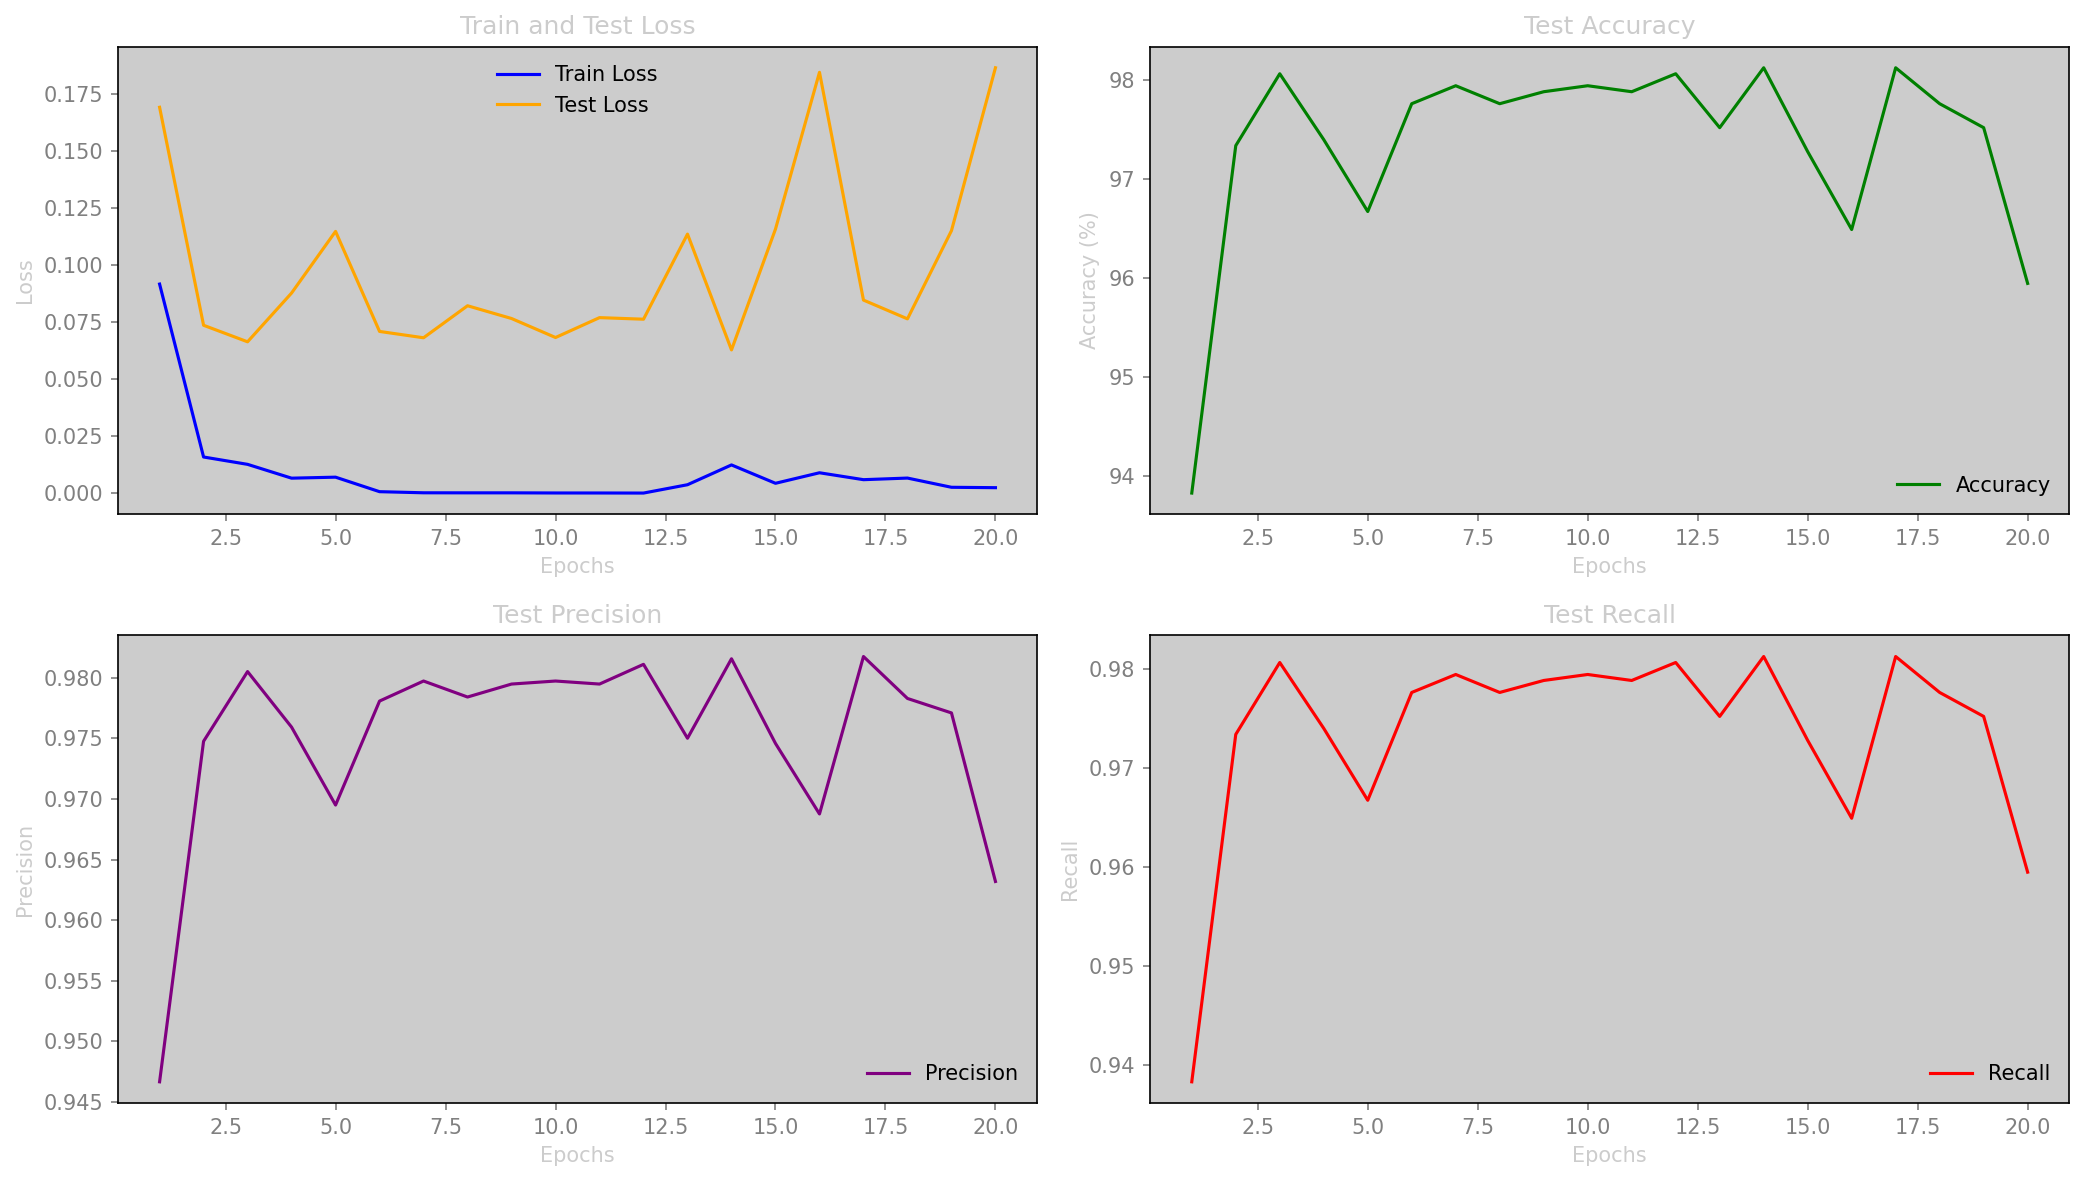

In [7]:
best_loss = get_best_loss()
model.load_state_dict(torch.load(f"model-{best_loss}.pth"))

metrics = {
    'Epochs': list(range(1, n_epochs + 1)),
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
}

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('training_metrics.csv', index=False)
print("Metrics saved to 'training_metrics.csv'")

# Plotting
plt.figure(figsize=(14, 8))

# Plotting Train and Test Loss
plt.subplot(2, 2, 1)
plt.plot(metrics['Epochs'], train_losses, label='Train Loss', color='blue')
plt.plot(metrics['Epochs'], test_losses, label='Test Loss', color='orange')
plt.title('Train and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(2, 2, 2)
plt.plot(metrics['Epochs'], accuracies, label='Accuracy', color='green')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Precision
plt.subplot(2, 2, 3)
plt.plot(metrics['Epochs'], precisions, label='Precision', color='purple')
plt.title('Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plotting Recall
plt.subplot(2, 2, 4)
plt.plot(metrics['Epochs'], recalls, label='Recall', color='red')
plt.title('Test Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Inference
- Load the best model
- Make predictions on 9 random images

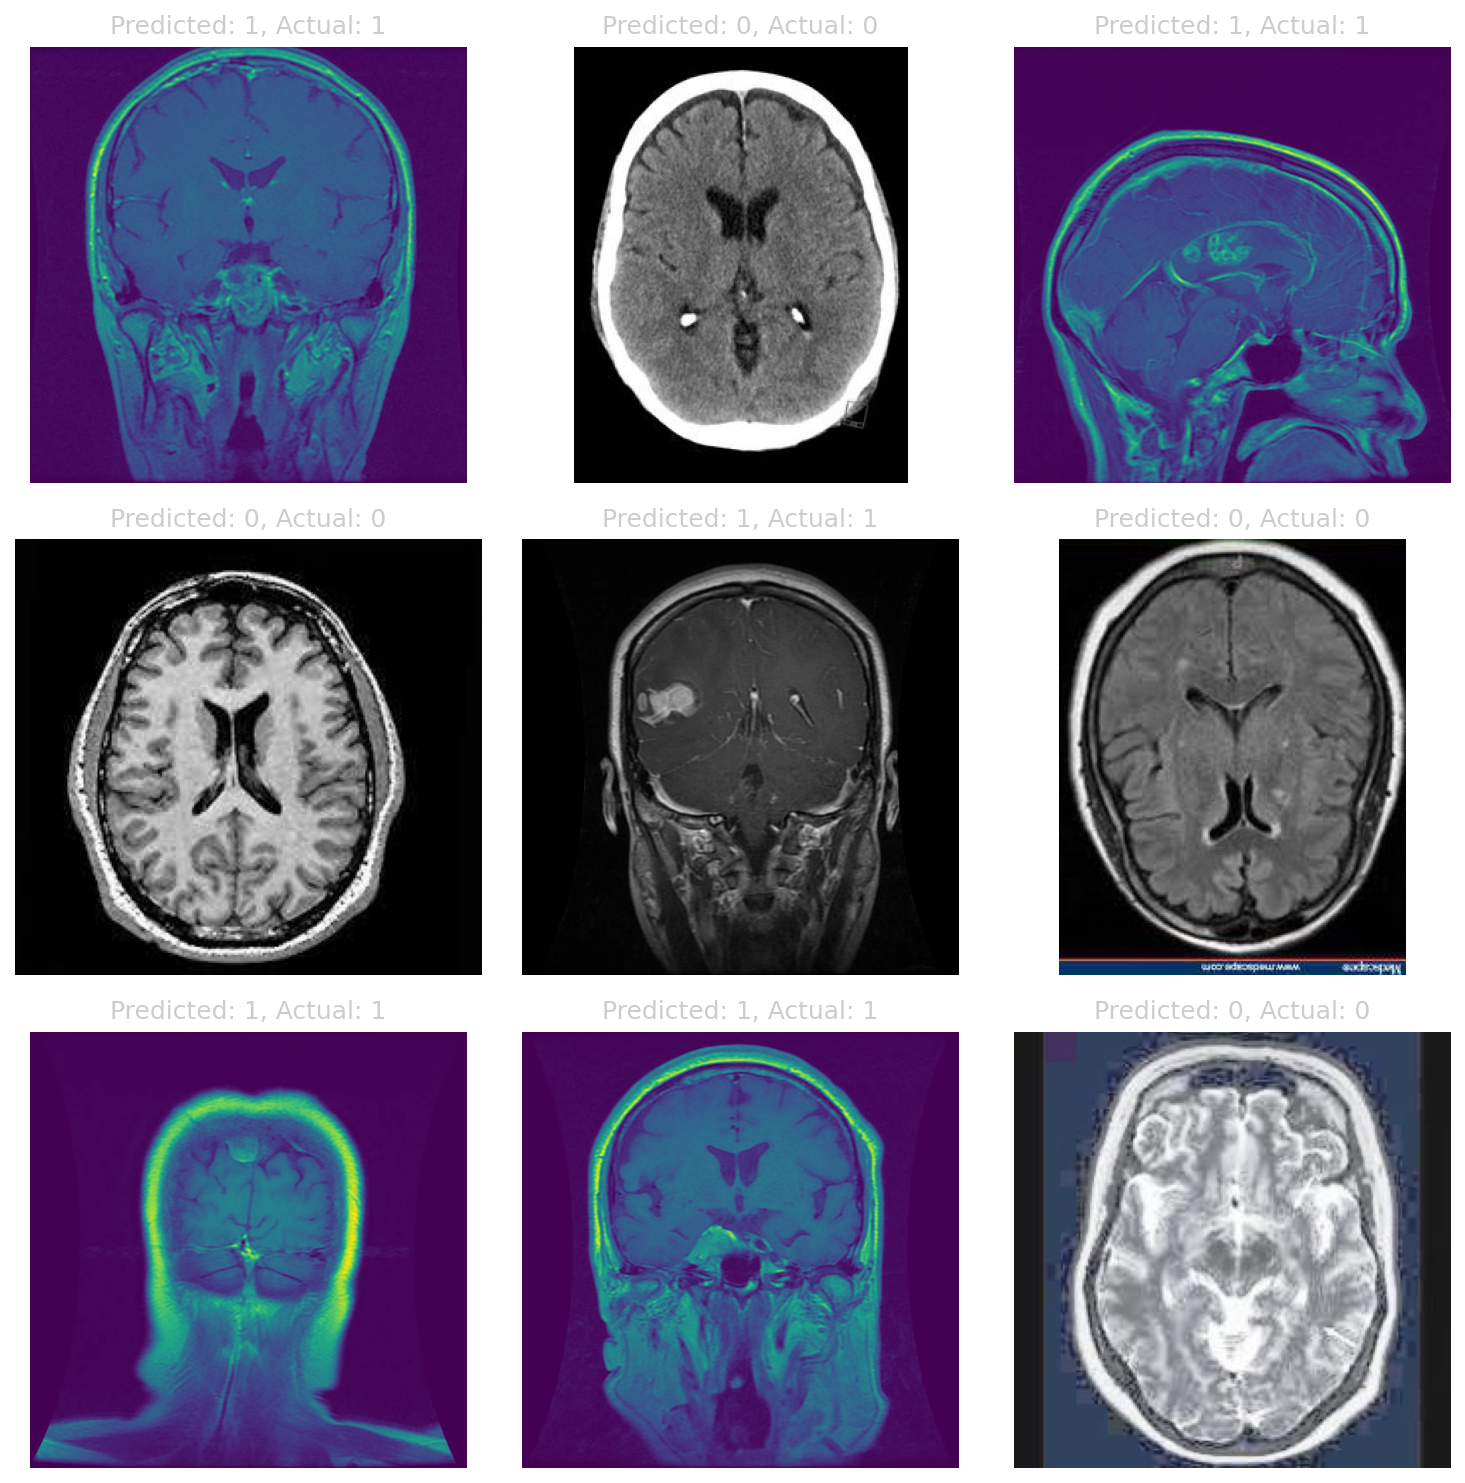

In [8]:
best_loss = get_best_loss()
model.load_state_dict(torch.load(f"model-{best_loss}.pth"))

model.eval()
sample_images = df_test.sample(9)
fig, axes = plt.subplots(3, 3, figsize=(10,10))
for ax, (img_path, label) in zip(axes.flatten(), sample_images.itertuples(index=False)):
    img = Image.open(img_path["path"])
    ax.imshow(img)
    ax.axis("off")

    img = transform(img.convert("RGB")).unsqueeze(0).to(device)
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    ax.set_title(f"Predicted: {predicted.item()}, Actual: {label}")
plt.tight_layout()
plt.show()